In [1]:
import pandas as pd

df = pd.read_csv('../results/sample_once_train_10k/fixed_seeds.csv', index_col=0)
df.sort_values(by=['method', 'influence_sign', 'seed', 'ratio', 'model_version', 'n_iterations', 'hard_constrained'], inplace=True)

# I ran some experiments twice because I set different influence signs for random and RAR aswell
# this drops all rows with EXACT duplicates
df.loc[df['method'] != 'IF', 'influence_sign'] = "abs"
df.drop_duplicates(inplace=True, keep='first')

In [2]:
print("Checking all runs")
print("In case of a run missing please use the following args to create run:\n\n")
missing = 0
for method in df['method'].unique():
    for ratio in df['ratio'].unique():
        for seed in df['seed'].unique():
            for n_iter in df['n_iterations'].unique():
                for hard_constrained in df['hard_constrained'].unique():
                    if method == 'IF':
                        for infl_sign in df['influence_sign'].unique():
                            printed = False 
                            for model_version in df['model_version'].unique():
                                subset = df.loc[
                                    (df['method'] == method) &
                                    (df['influence_sign'] == infl_sign) &
                                    (df['seed'] == seed) &
                                    (df['ratio'] == ratio) &
                                    (df['model_version'] == model_version) &
                                    (df['n_iterations'] == n_iter) &
                                    (df['hard_constrained'] == hard_constrained)
                                ]

                                if subset.empty:
                                    job = f'--ratio {ratio} --method {method} --n_iterations {n_iter} --seed {seed} --influence_sign {infl_sign}' 
                                    if hard_constrained:
                                        job += ' --hard_constrained'

                                    if not printed:
                                        print(job)
                                        printed = True
                    else:
                        subset = df.loc[
                                    (df['method'] == method) &
                                    (df['seed'] == seed) &
                                    (df['ratio'] == ratio) &
                                    (df['model_version'] == model_version) &
                                    (df['n_iterations'] == n_iter) &
                                    (df['hard_constrained'] == hard_constrained)
                                ]
                        
                        if subset.empty:
                            job = f'--ratio {ratio} --method {method} --n_iterations {n_iter} --seed {seed} --influence_sign {infl_sign}' 
                            if hard_constrained:
                                job += ' --hard_constrained'
                            print(job)

Checking all runs
In case of a run missing please use the following args to create run:




In [3]:
# check for duplicate entries with different results
print("\n\nChecking for duplicates")
for method in df['method'].unique():
    for ratio in df['ratio'].unique():
        for seed in df['seed'].unique():
            for n_iter in df['n_iterations'].unique():
                for hard_constrained in df['hard_constrained'].unique():
                    for infl_sign in df['influence_sign'].unique():
                        for model_version in df['model_version'].unique():
                            subset = df.loc[
                                (df['method'] == method) &
                                (df['seed'] == seed) &
                                (df['ratio'] == ratio) &
                                (df['model_version'] == model_version) &
                                (df['n_iterations'] == n_iter) &
                                (df['hard_constrained'] == hard_constrained) & 
                                (df['influence_sign'] == infl_sign)
                            ]

                            if subset.shape[0] > 1:
                                print(f"Duplicate: {method}, {infl_sign}, {seed}, {ratio}, {model_version}, {n_iter}, {hard_constrained}")



Checking for duplicates


# ABSOLUTE IF

n_iter: 10000, hard_constrained: True


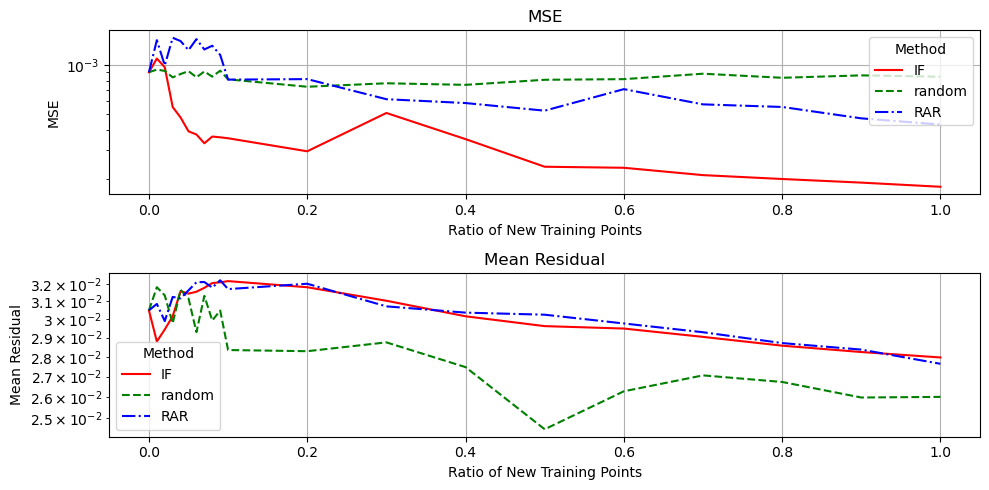

n_iter: 50000, hard_constrained: True


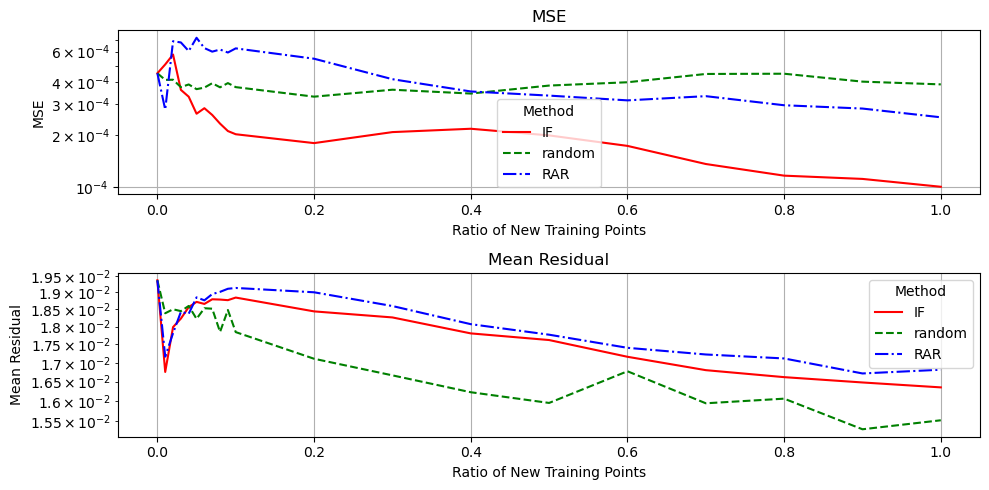

In [9]:
infl_sign = 'abs'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv('../results/sample_once_train_10k/fixed_seeds.csv', index_col=0)
df.sort_values(by=['method', 'influence_sign', 'seed', 'ratio', 'model_version', 'n_iterations', 'hard_constrained'], inplace=True)

# I ran some experiments twice because I set different influence signs for random and RAR aswell
# this drops all rows with EXACT duplicates
df.loc[df['method'] != 'IF', 'influence_sign'] = infl_sign
df.drop_duplicates(inplace=True, keep='first')

df = df.loc[df['influence_sign'] == infl_sign]
hard_constrained = True

# Assuming 'df' is your DataFrame already loaded
for n_iter in [10000, 50000]:
    # for hard_constrained in [True, False]:
        print(f"n_iter: {n_iter}, hard_constrained: {hard_constrained}")
        # Filter the DataFrame
        sub_df = df.loc[
            (df['model_version'] == 'test') &
            (df['n_iterations'] == n_iter) &
            (df['hard_constrained'] == hard_constrained)
        ]

        # Group by 'method' and 'ratio' and calculate the mean and standard deviation
        # We'll include 'control' in our methods list
        methods = ['IF', 'random', 'RAR']
        grouped = sub_df.groupby(['method', 'ratio'])
        mean_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].mean().reset_index()
        std_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].std().reset_index()

        # Define your methods, colors, and styles
        method_colors = {'IF': 'r', 'random': 'g', 'RAR': 'b',}
        method_styles = {'IF': '-', 'random': '--', 'RAR': '-.',}

        metrics = ['mse', 'mean_residual']#, 'l2_relative_error']
        metric_labels = {
            'mse': 'MSE',
            'mean_residual': 'Mean Residual',
            'l2_relative_error': 'L2 Relative Error'
        }

        # Create custom legend elements for methods
        method_legend_elements = [
            Line2D([0], [0], color=method_colors[method], linestyle=method_styles[method], label=method)
            for method in methods
        ]

        fig, ax = plt.subplots(nrows=2, figsize=(10, 5))

        for e, metric in enumerate(metrics):
            for method in methods:
                method_mean = mean_df[mean_df['method'] == method]
                method_std = std_df[std_df['method'] == method]

                color = method_colors[method]
                line_style = method_styles[method]

                ax[e].plot(method_mean['ratio'], method_mean[metric], color=color, linestyle=line_style)
                # ax[e].fill_between(
                #     method_mean['ratio'],
                #     method_mean[metric] - method_std[metric],
                #     method_mean[metric] + method_std[metric],
                #     color=color, alpha=0.1
                # )

            ax[e].set_title(metric_labels[metric])
            ax[e].set_xlabel('Ratio of New Training Points')
            ax[e].set_ylabel(metric_labels[metric])
            ax[e].set_yscale('log')
            ax[e].grid()
            # Add custom legend
            ax[e].legend(handles=method_legend_elements, title='Method')

        plt.tight_layout()
        plt.show()

# POSITIVE IF

n_iter: 10000, hard_constrained: True


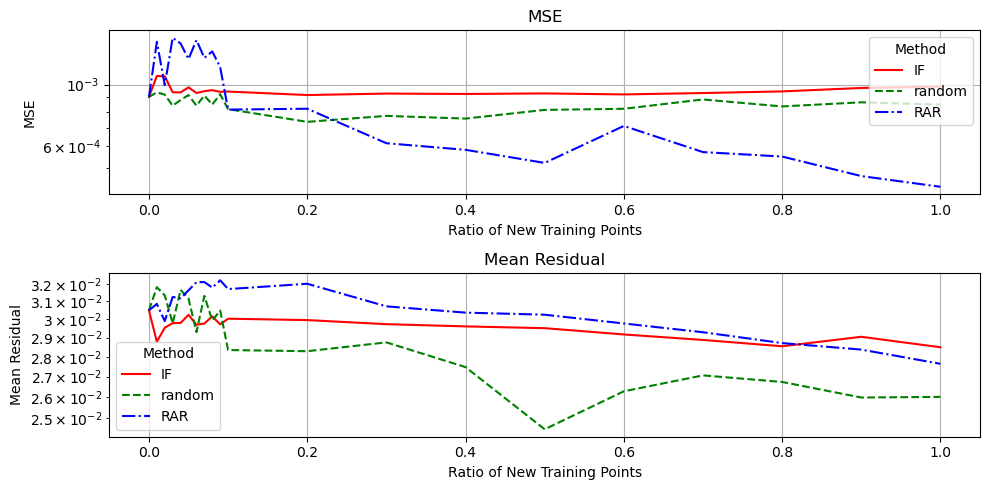

n_iter: 50000, hard_constrained: True


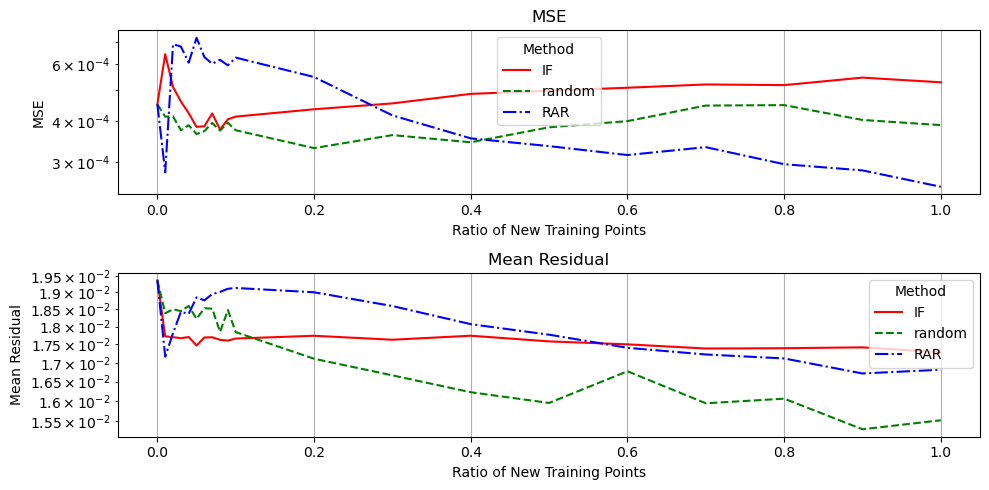

In [5]:
infl_sign = 'pos'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv('../results/sample_once_train_10k/fixed_seeds.csv', index_col=0)
df.sort_values(by=['method', 'influence_sign', 'seed', 'ratio', 'model_version', 'n_iterations', 'hard_constrained'], inplace=True)

# I ran some experiments twice because I set different influence signs for random and RAR aswell
# this drops all rows with EXACT duplicates
df.loc[df['method'] != 'IF', 'influence_sign'] = infl_sign
df.drop_duplicates(inplace=True, keep='first')

df = df.loc[df['influence_sign'] == infl_sign]
hard_constrained = True

# Assuming 'df' is your DataFrame already loaded
for n_iter in [10000, 50000]:
    # for hard_constrained in [True, False]:
        print(f"n_iter: {n_iter}, hard_constrained: {hard_constrained}")
        # Filter the DataFrame
        sub_df = df.loc[
            (df['model_version'] == 'test') &
            (df['n_iterations'] == n_iter) &
            (df['hard_constrained'] == hard_constrained)
        ]

        # Group by 'method' and 'ratio' and calculate the mean and standard deviation
        # We'll include 'control' in our methods list
        methods = ['IF', 'random', 'RAR']
        grouped = sub_df.groupby(['method', 'ratio'])
        mean_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].mean().reset_index()
        std_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].std().reset_index()

        # Define your methods, colors, and styles
        method_colors = {'IF': 'r', 'random': 'g', 'RAR': 'b',}
        method_styles = {'IF': '-', 'random': '--', 'RAR': '-.',}

        metrics = ['mse', 'mean_residual']#, 'l2_relative_error']
        metric_labels = {
            'mse': 'MSE',
            'mean_residual': 'Mean Residual',
            'l2_relative_error': 'L2 Relative Error'
        }

        # Create custom legend elements for methods
        method_legend_elements = [
            Line2D([0], [0], color=method_colors[method], linestyle=method_styles[method], label=method)
            for method in methods
        ]

        fig, ax = plt.subplots(nrows=2, figsize=(10, 5))

        for e, metric in enumerate(metrics):
            for method in methods:
                method_mean = mean_df[mean_df['method'] == method]
                method_std = std_df[std_df['method'] == method]

                color = method_colors[method]
                line_style = method_styles[method]

                ax[e].plot(method_mean['ratio'], method_mean[metric], color=color, linestyle=line_style)
                # ax[e].fill_between(
                #     method_mean['ratio'],
                #     method_mean[metric] - method_std[metric],
                #     method_mean[metric] + method_std[metric],
                #     color=color, alpha=0.1
                # )

            ax[e].set_title(metric_labels[metric])
            ax[e].set_xlabel('Ratio of New Training Points')
            ax[e].set_ylabel(metric_labels[metric])
            ax[e].set_yscale('log')
            ax[e].grid()
            # Add custom legend
            ax[e].legend(handles=method_legend_elements, title='Method')

        plt.tight_layout()
        plt.show()

# NEGATIVE IF

n_iter: 10000, hard_constrained: True


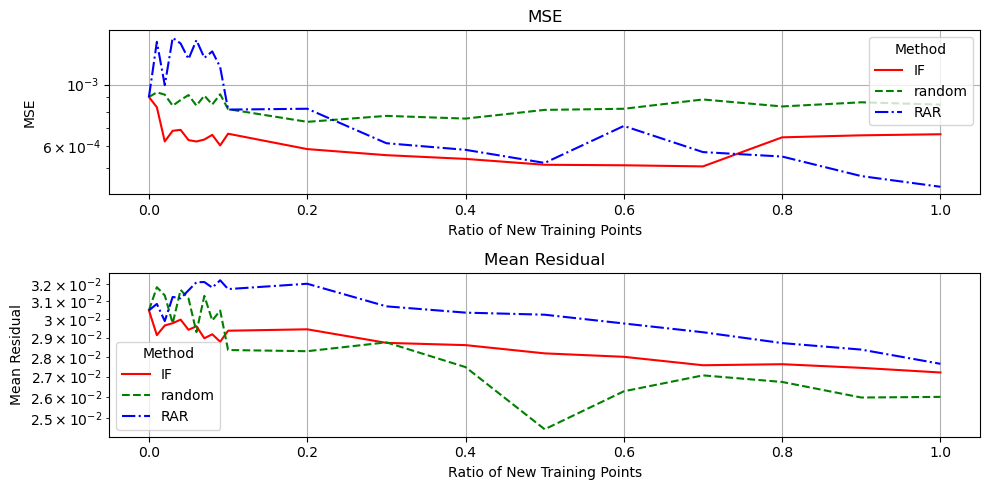

n_iter: 50000, hard_constrained: True


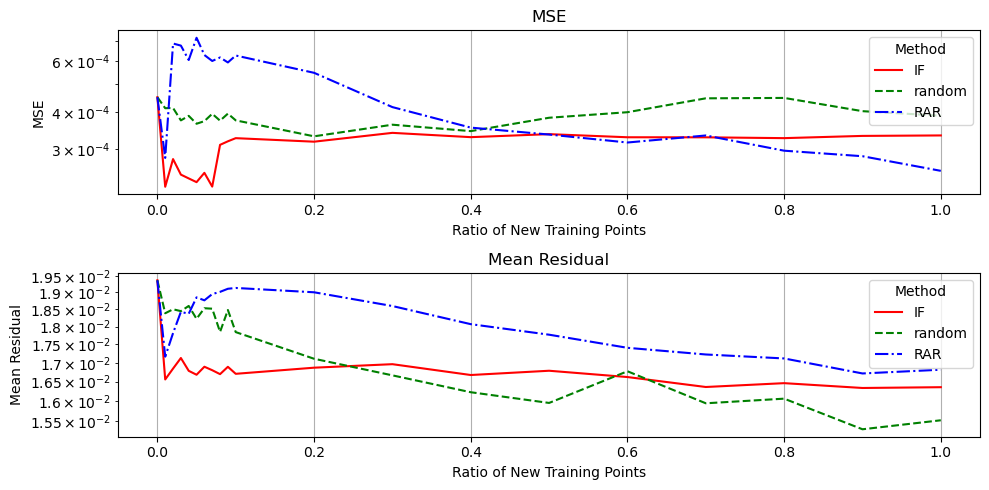

In [6]:
infl_sign = 'neg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv('../results/sample_once_train_10k/fixed_seeds.csv', index_col=0)
df.sort_values(by=['method', 'influence_sign', 'seed', 'ratio', 'model_version', 'n_iterations', 'hard_constrained'], inplace=True)

# I ran some experiments twice because I set different influence signs for random and RAR aswell
# this drops all rows with EXACT duplicates
df.loc[df['method'] != 'IF', 'influence_sign'] = infl_sign
df.drop_duplicates(inplace=True, keep='first')

df = df.loc[df['influence_sign'] == infl_sign]
hard_constrained = True

# Assuming 'df' is your DataFrame already loaded
for n_iter in [10000, 50000]:
    # for hard_constrained in [True, False]:
        print(f"n_iter: {n_iter}, hard_constrained: {hard_constrained}")
        # Filter the DataFrame
        sub_df = df.loc[
            (df['model_version'] == 'test') &
            (df['n_iterations'] == n_iter) &
            (df['hard_constrained'] == hard_constrained)
        ]

        # Group by 'method' and 'ratio' and calculate the mean and standard deviation
        # We'll include 'control' in our methods list
        methods = ['IF', 'random', 'RAR']
        grouped = sub_df.groupby(['method', 'ratio'])
        mean_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].mean().reset_index()
        std_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].std().reset_index()

        # Define your methods, colors, and styles
        method_colors = {'IF': 'r', 'random': 'g', 'RAR': 'b',}
        method_styles = {'IF': '-', 'random': '--', 'RAR': '-.',}

        metrics = ['mse', 'mean_residual']#, 'l2_relative_error']
        metric_labels = {
            'mse': 'MSE',
            'mean_residual': 'Mean Residual',
            'l2_relative_error': 'L2 Relative Error'
        }

        # Create custom legend elements for methods
        method_legend_elements = [
            Line2D([0], [0], color=method_colors[method], linestyle=method_styles[method], label=method)
            for method in methods
        ]

        fig, ax = plt.subplots(nrows=2, figsize=(10, 5))

        for e, metric in enumerate(metrics):
            for method in methods:
                method_mean = mean_df[mean_df['method'] == method]
                method_std = std_df[std_df['method'] == method]

                color = method_colors[method]
                line_style = method_styles[method]

                ax[e].plot(method_mean['ratio'], method_mean[metric], color=color, linestyle=line_style)
                # ax[e].fill_between(
                #     method_mean['ratio'],
                #     method_mean[metric] - method_std[metric],
                #     method_mean[metric] + method_std[metric],
                #     color=color, alpha=0.1
                # )

            ax[e].set_title(metric_labels[metric])
            ax[e].set_xlabel('Ratio of New Training Points')
            ax[e].set_ylabel(metric_labels[metric])
            ax[e].set_yscale('log')
            ax[e].grid()
            # Add custom legend
            ax[e].legend(handles=method_legend_elements, title='Method')

        plt.tight_layout()
        plt.show()

# IFs COMPARISON

n_iter: 10000, hard_constrained: True


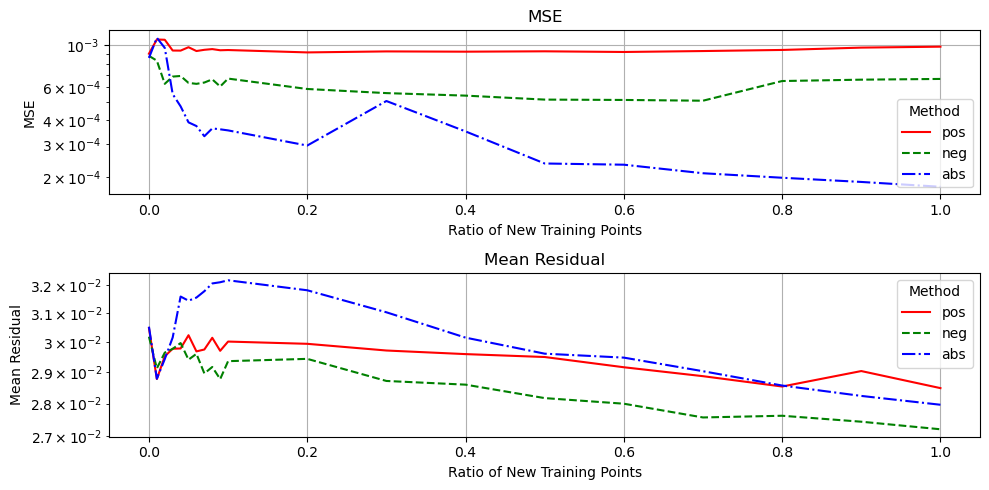

n_iter: 50000, hard_constrained: True


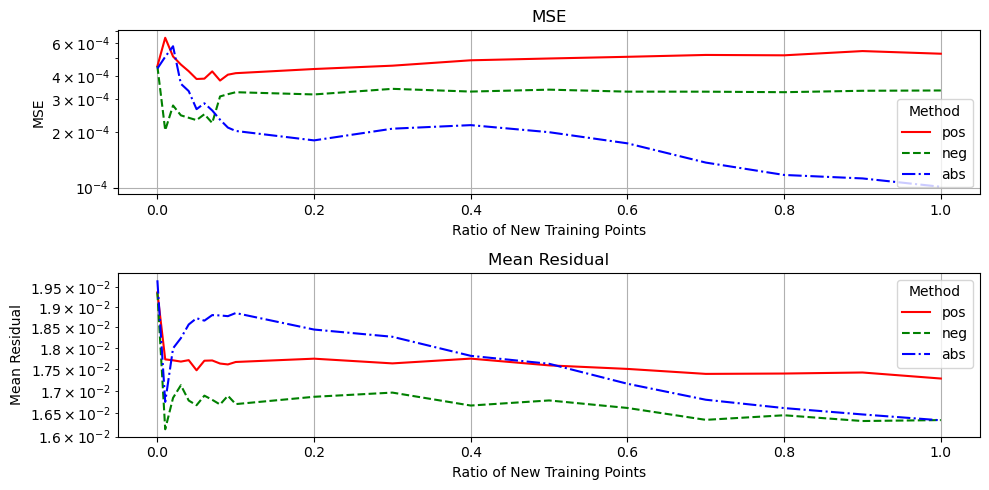

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv('../results/sample_once_train_10k/fixed_seeds.csv', index_col=0)
df.sort_values(by=['method', 'influence_sign', 'seed', 'ratio', 'model_version', 'n_iterations', 'hard_constrained'], inplace=True)

# I ran some experiments twice because I set different influence signs for random and RAR aswell
# this drops all rows with EXACT duplicates
df = df.loc[df['method'] == 'IF']
hard_constrained = True 

# Assuming 'df' is your DataFrame already loaded
for n_iter in [10000, 50000]:
    # for hard_constrained in [True, False]:
        print(f"n_iter: {n_iter}, hard_constrained: {hard_constrained}")
        # Filter the DataFrame
        sub_df = df.loc[
            (df['model_version'] == 'test') &
            (df['n_iterations'] == n_iter) &
            (df['hard_constrained'] == hard_constrained)
        ]

        # Group by 'method' and 'ratio' and calculate the mean and standard deviation
        # We'll include 'control' in our methods list
        signs = ['pos', 'neg', 'abs']
        grouped = sub_df.groupby(['influence_sign', 'ratio'])
        mean_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].mean().reset_index()
        std_df = grouped[['mse', 'l2_relative_error', 'mean_residual']].std().reset_index()

        # Define your methods, colors, and styles
        method_colors = {'pos': 'r', 'neg': 'g', 'abs': 'b',}
        method_styles = {'pos': '-', 'neg': '--', 'abs': '-.',}

        metrics = ['mse', 'mean_residual']#, 'l2_relative_error']
        metric_labels = {
            'mse': 'MSE',
            'mean_residual': 'Mean Residual',
            'l2_relative_error': 'L2 Relative Error'
        }

        # Create custom legend elements for methods
        method_legend_elements = [
            Line2D([0], [0], color=method_colors[method], linestyle=method_styles[method], label=method)
            for method in signs
        ]

        fig, ax = plt.subplots(nrows=2, figsize=(10, 5))

        for e, metric in enumerate(metrics):
            for sign in signs:
                sign_mean = mean_df[mean_df['influence_sign'] == sign]
                sign_std = std_df[std_df['influence_sign'] == sign]

                color = method_colors[sign]
                line_style = method_styles[sign]

                ax[e].plot(sign_mean['ratio'], sign_mean[metric], color=color, linestyle=line_style)
                # ax[e].fill_between(
                #     method_mean['ratio'],
                #     method_mean[metric] - method_std[metric],
                #     method_mean[metric] + method_std[metric],
                #     color=color, alpha=0.1
                # )

            ax[e].set_title(metric_labels[metric])
            ax[e].set_xlabel('Ratio of New Training Points')
            ax[e].set_ylabel(metric_labels[metric])
            ax[e].set_yscale('log')
            ax[e].grid()
            # Add custom legend
            ax[e].legend(handles=method_legend_elements, title='Method')

        plt.tight_layout()
        plt.show()